## Библиотеки

Первым этапом анализа данных и разработки модели является импортирование нужных библиотек

In [132]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

## Датасет

Прежде чем разбираться с моделями, нам стоит происследовать правильно ли загружены данные и а так же рассмотреть их распредиеление и проверить наличие "аномалий".

In [156]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

In [134]:
df_train.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
37934,09/20/2021/10:20,30.3541,44.95,5.07481,546.600,62.210,69704.997753
31917,08/09/2021/15:30,35.5865,41.38,5.05112,623.700,284.900,99443.498147
28331,07/15/2021/17:50,30.8485,72.70,5.06554,412.500,134.900,89005.901292
19788,05/17/2021/10:00,25.6676,55.79,5.06348,660.800,653.600,75247.019863
23348,06/11/2021/03:20,20.3425,66.28,0.08446,0.066,0.107,77042.028189


## Первичный анализ данных

Посмотрим как распределятся все характеиристики датафрейма, обратим внимание на то что "Скорость ветра" и "Диффузивные потоки" имеют небольшую дисперсию.

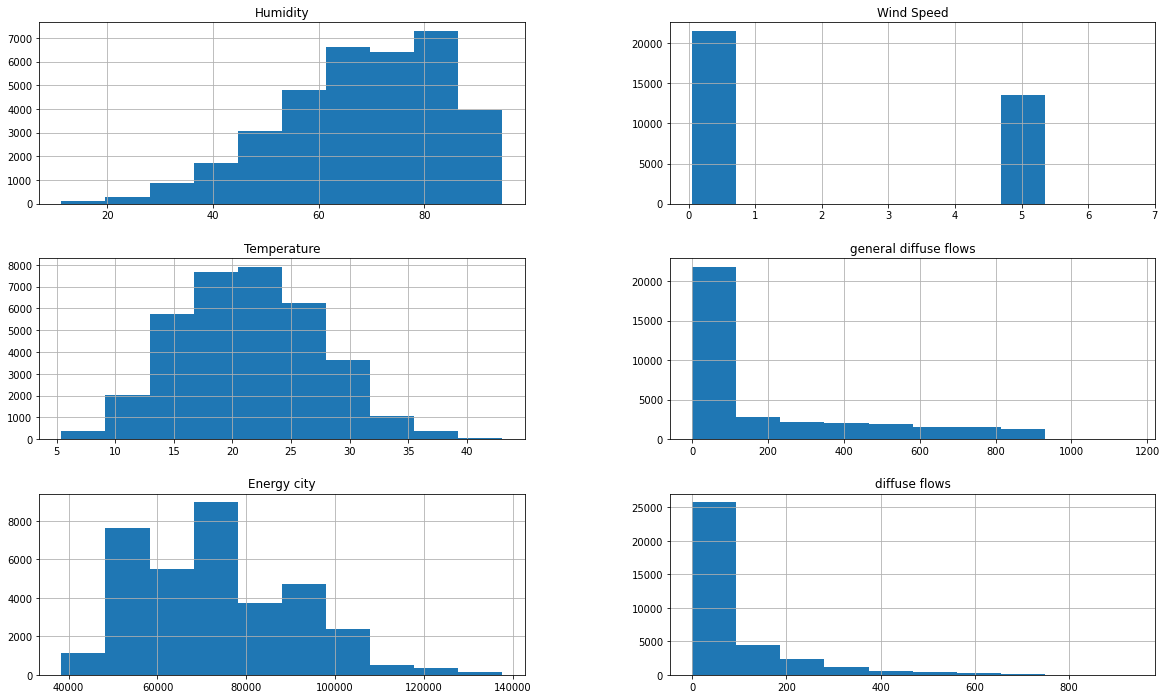

In [135]:
features = list(set(df_train.columns) - set(['DateTime']))

_ = df_train[features].hist(figsize=(20,12))

Посмотрим на то как значения корррелируют между собой, если какая-то пара значений имеет большой коэффициент то одно из них можно выкинуть

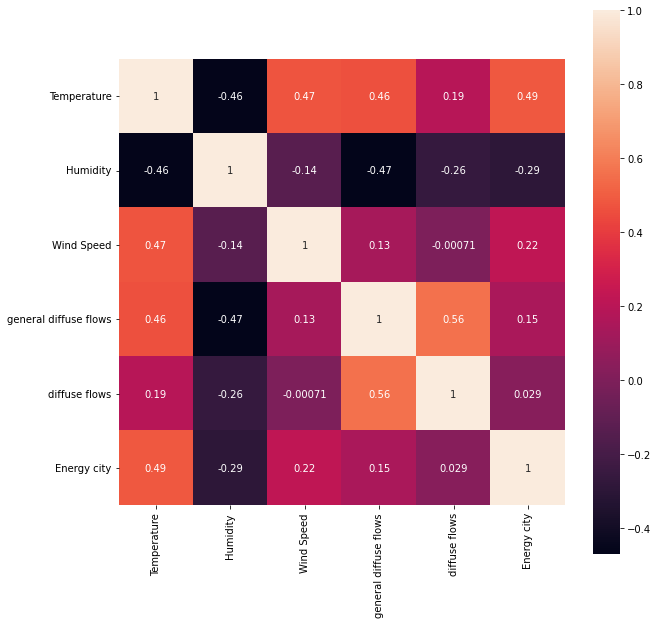

In [136]:
plt.rcParams['figure.figsize']=(10,10)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Предобработка данных

Стоить заметить что столбец **DateTime** имеет тип данных object, что говорит о некроореткном считывании типа данных, сменим тип его данных на data_time



In [137]:
df_train["DateTime"] = pd.to_datetime(df_train["DateTime"])

Большинство моделей плохо работают с временными рядами, по этому выделим из этого столбца самые главные показатели:

* Месяц
* Час

*Для повышения точности этот список можно расширить.* 

In [138]:
df_train["Month"] = pd.to_datetime(df_train["DateTime"]).dt.month
df_train["Hour"] = pd.to_datetime(df_train["DateTime"]).dt.hour 

In [139]:
df_train.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city,Month,Hour
37934,2021-09-20 10:20:00,30.3541,44.95,5.07481,546.600,62.210,69704.997753,9,10
31917,2021-08-09 15:30:00,35.5865,41.38,5.05112,623.700,284.900,99443.498147,8,15
28331,2021-07-15 17:50:00,30.8485,72.70,5.06554,412.500,134.900,89005.901292,7,17
19788,2021-05-17 10:00:00,25.6676,55.79,5.06348,660.800,653.600,75247.019863,5,10
23348,2021-06-11 03:20:00,20.3425,66.28,0.08446,0.066,0.107,77042.028189,6,3


Присутпим к созаднию собственной **обучающей** и **тестовой** выборки.

In [140]:
X = df_train.drop(["Energy city", "DateTime"], axis = 1)
y = df_train["Energy city"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [141]:
X_train.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Month,Hour
20796,22.0626,75.60,5.06966,673.300,664.600,5,10
12516,21.8875,49.68,5.06348,0.059,0.096,3,22
26315,29.5713,69.85,5.07069,386.300,308.800,7,17
28424,30.3438,65.90,5.07481,504.300,91.000,7,9
19952,25.6882,62.90,0.07313,899.000,125.200,5,13


## Выбор модели обучения

Многообразие выбора моделей линейной регресии, попробуй все варианты и узнай кто из них лучше всего справляется с этой задачей.

**Важно**: *не забывай что у каждой модели есть свои параметры которые стоить изменить.*

In [143]:
models = [LinearRegression(),        # метод наименьших квадратов
	          RandomForestRegressor(), # случайный лес
	          KNeighborsRegressor(),   # метод ближайших соседей
	          SVR(kernel='linear')]    # метод опорных векторов с линейным ядром

In [144]:
model = models[0].fit(X_train, y_train)

За счет обученой модели **предскажем** значения целового столбца.

In [145]:
y_prediction = model.predict(X_test)

В качестве метрики оценки оценивания качества модели будем использовать **коэффициент детерминации**, или R². Так как он используется в проверке тестового решения задачи. Отличительной чертой R² является удобство интерпритации ведь его значения всегда будут между **-∞** и **1**.



In [146]:
r2_score(y_test, model.predict(X_test))

0.6195285526653613

## Генерация ответа

In [157]:
X = df_test.drop(["Energy city", "DateTime"], axis = 1)
X["Month"] = pd.to_datetime(df_test["DateTime"]).dt.month
X["Hour"] = pd.to_datetime(df_test["DateTime"]).dt.hour 

In [158]:
df_test["Energy city"] = model.predict(X)

In [159]:
df_test.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
15506,04/17/2021/16:20,25.5028,29.73,0.08755,615.500,664.800,75708.735796
51943,12/26/2021/17:10,18.4576,54.44,0.08755,19.120,19.340,75680.118633
212,01/01/2021/11:20,17.5924,57.23,0.07828,396.600,40.660,70318.235851
11210,03/18/2021/20:20,14.8526,72.30,0.08343,0.062,0.148,82163.462118
16307,04/23/2021/05:50,17.0774,80.60,0.08240,0.018,0.204,60555.845016


In [163]:
df_test.sort_index().to_csv("submit.csv")